#  Viridisify

As usual this is available and as been written as a [jupyter notebook](https://jupyter.org) if you like to play with the code feel free to [fork it](https://github.com/carreau/posts/).

---

The jet colormap (AKA "rainbow") is ubiquitous, there are a lot of [controverse](https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/) as to wether it is (from far)  the best one. And better options [have been designed](https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/).

The question is, if you have a graph that use a specific colormap, and you would prefer for it to use another one; what do you do ?

Well is you have th eunderlying data that's easy, but it's not always the case. 

So how to remap a plot which has a non perceptually uniform colormap using another ? What's happend if yhere are encoding artificats and my pixels colors are slightly off ?

I came up with a prototype a few month ago, and was asked recently by @stefanv to "correct" a animated plot of huricane Matthew, where the "jet" colormap seem to provide an [illusion of growth](https://twitter.com/rsimmon/status/784112213627764737):

https://twitter.com/stefanvdwalt/status/784429257556492288


Let's see how we can convert a "Jet" image to a viridis based one. We'll first need some assumptions:

- This assume that you "know" the initial color map of a plot, and that the emcoding/compressing process of the plot will not change the colors "too much".
- There are pixels in the image which are not part of the colormap (typically text, axex, cat pictures....)


We will try to remap all the pixels that fall not "too far" from the initial colormap to the new colormap. 

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import matplotlib.colors as colors

In [3]:
!rm *.png *.gif out*

rm: output.gif: No such file or directory


I used the following to convert from mp4 to image sequence (8 fps determined manually). 
Sequence of images to video, and video to gif (quality is better than to gif dirrectly):

```
$ ffmpeg -i INPUT.mp4 -r 8 -f image2 img%02d.png
$ ffmpeg -framerate 8 -i vir-img%02d.png -c:v libx264 -r 8 -pix_fmt yuv420p out.mp4
$ ffmpeg -i out.mp4  output.gif
```

In [4]:
%%bash
ffmpeg -i input.mp4 -r 8 -f image2 img%02d.png -loglevel panic

Let's take our image without the alpha channel, so only the first 3 components:

In [5]:
import matplotlib.image as mpimg
img = mpimg.imread('img01.png')[:,:,:3]

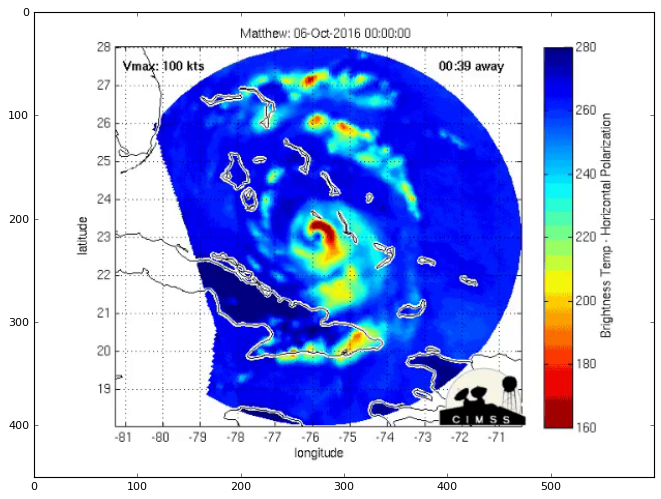

In [6]:
fig, ax = plt.subplots()
ax.imshow(img)
fig.set_figheight(10)
fig.set_figwidth(10)

As you can see it does use "Jet" (most likely),

let's look at the repartitions of pixels on the RGB space...

In [7]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

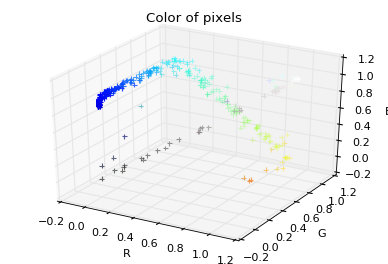

In [8]:
def rep(im, cin=None, sub=128):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    pp = im.reshape((-1,3)).T[:,::300]
    
    if cin:
        cmapin = plt.get_cmap(cin)
        cmap256 = colors.makeMappingArray(sub, cmapin)[:, :3].T
        ax.scatter(cmap256[0], cmap256[1], cmap256[2], marker='.', label='colormap', c=range(sub), cmap=cin, edgecolor=None)
    
    ax.scatter(pp[0], pp[1], pp[2], c=pp.T, marker='+')
    
    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')
    ax.set_title('Color of pixels')
    if cin:
        ax.legend()
    return ax
    
ax = rep(img)

We can see a specific clusers of pixel, let's plot the location of our "Jet" colormap and a diagonal of "gray".
We can guess the effect of various compressions artifacts have jittered the pixels slightly away from their original location.

Let's look at where the jet colormap is supposed to fall:

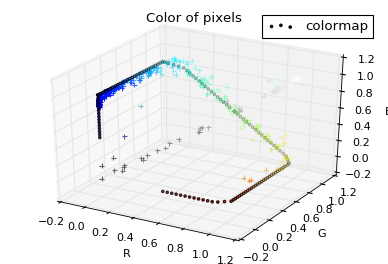

In [9]:
rep(img, 'jet')

Ok, that's pretty accurate, we also see that our selected graph does nto use the full extent of jet.

in order to find all the pixels that uses "Jet" efficiently we will use `scipy.spatial.KDTree` in the colorspace. In particular we will subsample the initial colormap in `sub=256` subsamples, and collect only pixels that are within `d=0.2` of this subsample, and map each of these pixels to the closer subsample. 

As we know the subsampling of the initial colormap, we can also determine the output colors. 

The Pixels that are "too far" from the pixels of the colormap are keep unchanged. 

increasing 256 to higher value will give a smoother final colormap. 

In [10]:
from scipy.spatial import cKDTree

In [11]:
def convert(sub=256, d=0.2, cin='jet', cout='viridis', img=img, show=True):
    viridis = plt.get_cmap(cout)
    cmapin = plt.get_cmap(cin)
    cmap256 = colors.makeMappingArray(sub, cmapin)[:, :3]
    original_shape = img.shape
    img_data = img.reshape((-1,3))
    
    # this will efficiently find the pixels "close" to jet
    # and assign them to which point (from 1 to 256) they are on the colormap.
    K = cKDTree(cmap256)
    res = K.query(img_data, distance_upper_bound=d)
    
    indices = res[1]
    l = len(cmap256)
    indices = indices.reshape(original_shape[:2])
    remapped = indices

    indices.max()

    mask = (indices == l)

    remapped = remapped / (l-1)
    mask = np.stack( [mask]*3, axis=-1)

    # here we add only these pixel and plot them again with viridis.
    blend = np.where(mask, img, viridis(remapped)[:,:,:3])
    if show:
        fig, ax = plt.subplots()
        fig.set_figheight(10)
        fig.set_figwidth(10)
        ax.imshow(blend)
    return blend

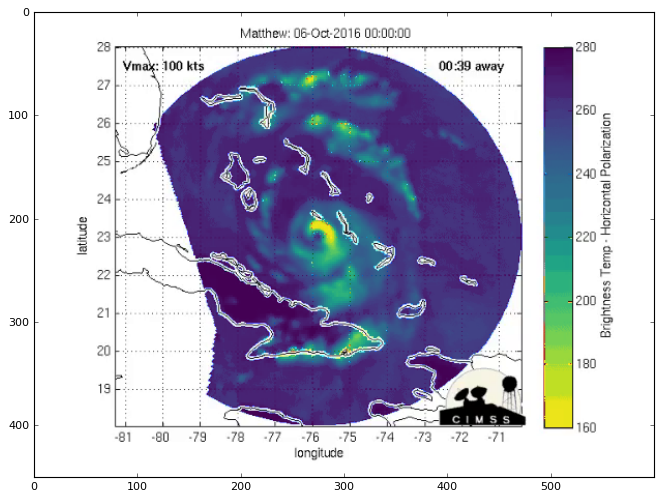

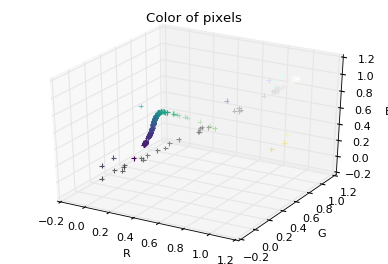

In [12]:
res = convert(img=img)
rep(res)

Let's loot at what happend if we decrease our leniency for the "proximity" of each pixel to the jet colormap:

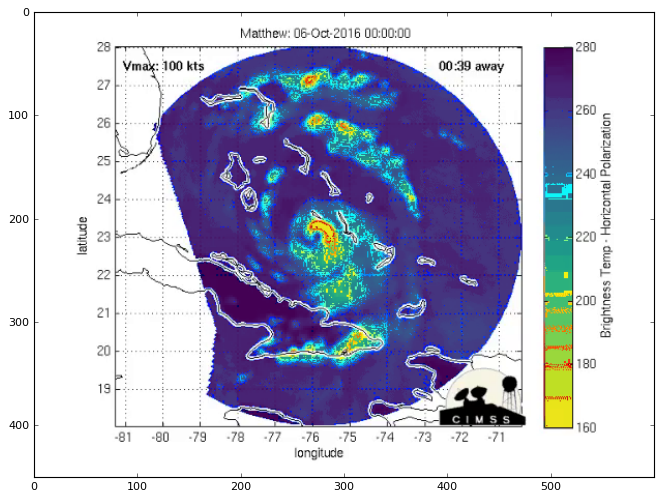

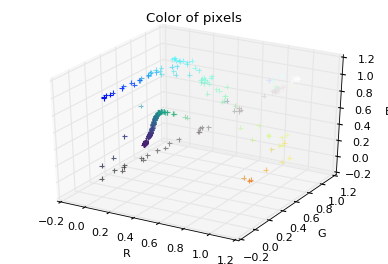

In [13]:
rep(convert(img=img, d=0.05))

Ouch ve definitively missed some pixels.

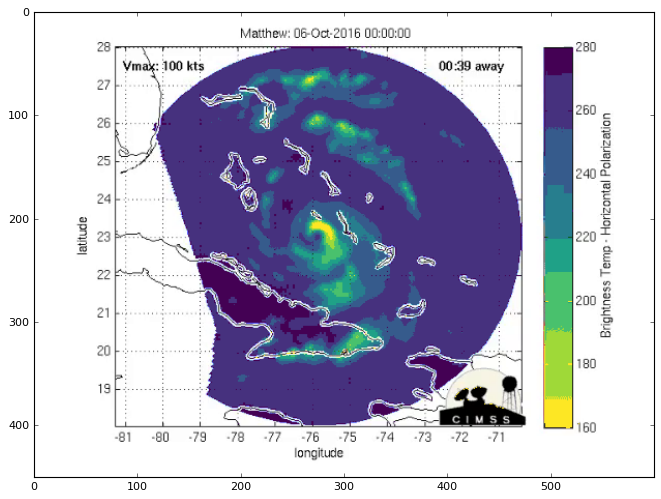

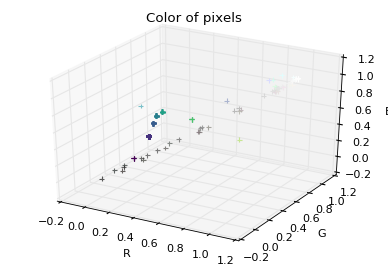

In [14]:
rep(convert(img=img, sub=8, d=0.4))

Subsampling to 8 colors (see above) forces us to increase or distance to accept points, and hint the non-linearity of "Jet" as seen in the colorbar.

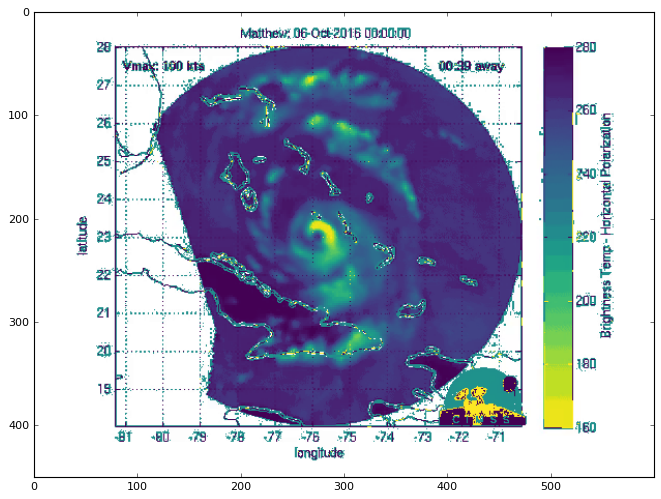

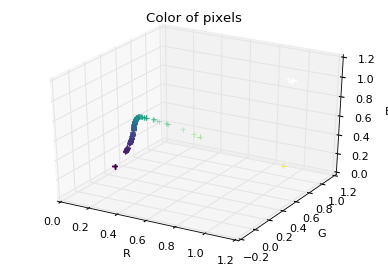

In [15]:
rep(convert(img=img, sub=256, d=0.7))

Beeing too lenient on the distance between the colormap and the pixel will change the color of undesired part of our image. 

Also look at our clean image that does nto scatter our pixel in RGB space !

Ok, we've played enough, let's convert all our images and re-make a gif/mp4 out of it...

In [16]:
tpl = 'img%02d.png'
tplv = 'vir-img%02d.png'
for i in range(1,18):
    img = mpimg.imread(tpl%i)[:,:,:3]
    vimg = convert(show=False, img=img)
    mpimg.imsave(tplv %i, vimg)

In [17]:
%%bash
ffmpeg -framerate 8 -i vir-img%02d.png -c:v libx264 -r 8 -pix_fmt yuv420p out.mp4 -y -loglevel panic

In [18]:
%%bash
ffmpeg -i out.mp4  output.gif -y -loglevel panic

Enjoy the result, and see how the north part of the huricane does not look like getting that much increase in intensity ! 

https://twitter.com/Mbussonn/status/784447098963972098

It's not a reason not to stay safe from huricanes.

--- 

Thanks to Stefan Van der Walt, and Nathaniel Smith for inspiration and helpful discussion. 

--- 

Notes:

Michael Ayes [asks](https://twitter.com/michaelaye/status/784478461926645760):

> that’s cool, but technically, that’s viridis_r, isn’t it?


That's discutable as I do a map from Jet to Viridis, the authors of the initial  graph seem to have user `jet_r` (reversed jet) so the final version looks like `viridis_r` (reversed viridis). More generally if the the original graph had used f(jet), then the final version woudl be close to f(viridis).

As usual please feel free to ask questions or send me updates, as my english is likely far from perfect.